# ImageContainer class
Squidpy provides an `ImageContainer` class that wraps `Xarray` to store several high-resolution images in the same coordinate system. It can be instanciated from a `.tif` or `.jpeg` file or a numpy array. For `.tif`, it supports lazy loading, only reading the data when necessary. The images are saved as a `xarray.Dataset` in the `.data` attribute.

The `ImageContainer` contains methods for extracting crops from the images, which can be e.g. used to generate image crops centered on visium spots.

This notebook showcases the different methods of `ImageContainer`.


In [1]:
# import modules
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import squidpy as sq

## Init ImageContainer
The constructor takes as input a path to an image on disk, or a numpy array. The loaded image will be stored in a layer in the `xarray.Dataset` with the name `img_id`. By default the name is `image`. The `lazy` argument controls if images are loaded in memory directly, or lazily.

In [2]:
# set path to dataset
BASE_PATH = "../../data"
dataset_folder = os.path.join(BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla")
# load data
img = sq.im.ImageContainer(os.path.join(dataset_folder, 'V1_Adult_Mouse_Brain_image.tif'))

/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


`read_visium_data` is a convenience function that loads both the AnnData object and the ImageContainer object from a given folder containing a visium dataset. 
Internally, it calls `ImageContainer()` with default aguments.

In [3]:
# load data
#adata, img = sq.read_visium_data(dataset_folder)

## ImageContainer is a wrapper around xarray.Dataset
The loaded image is contained in `img.data`, which is an `xarray.Dataset`. 

In [4]:
print(img)
display(img.data)
print(img.shape)

ImageContainer object with 1 layers
    image: y (11757), x (11291), channels (3)



<xarray.Dataset>
Dimensions:   (channels: 3, x: 11291, y: 11757)
Coordinates:
  * channels  (channels) int64 1 2 3
Dimensions without coordinates: x, y
Data variables:
    image     (y, x, channels) uint8 129 134 127 129 132 ... 133 131 131 131 128

(11757, 11291)


You can add more images to `img` by calling `add_img()`. The added images need to have the same x and y coordinates as the original image, but can have different channel dimensions.
This is useful when you have e.g. an RGB Histology image and would like to add a binary segmentation mask to `img`.

In [5]:
# create dummy mask, with dimensions y, x, channels
mask = np.zeros([img.shape[0], img.shape[1], 1])
# add mask to img
img.add_img(mask, img_id='mask', channel_id='segmentation')

print(img)
display(img.data)

ImageContainer object with 2 layers
    image: y (11757), x (11291), channels (3)
    mask: y (11757), x (11291), segmentation (1)



<xarray.Dataset>
Dimensions:   (channels: 3, segmentation: 1, x: 11291, y: 11757)
Coordinates:
  * channels  (channels) int64 1 2 3
Dimensions without coordinates: segmentation, x, y
Data variables:
    image     (y, x, channels) uint8 129 134 127 129 132 ... 133 131 131 131 128
    mask      (y, x, segmentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

access individual image layers using xarrays dictionary-like access

In [6]:
display(img['image'])

<xarray.DataArray 'image' (y: 11757, x: 11291, channels: 3)>
array([[[129, 134, 127],
        [129, 132, 127],
        [129, 132, 127],
        ...,
        [127, 129, 123],
        [128, 129, 125],
        [128, 130, 126]],

       [[130, 134, 127],
        [131, 135, 128],
        [130, 132, 128],
        ...,
        [128, 130, 125],
        [128, 130, 126],
        [128, 129, 124]],

       [[128, 136, 128],
        [129, 135, 128],
        [127, 132, 126],
        ...,
...
        ...,
        [131, 133, 129],
        [131, 132, 128],
        [128, 129, 125]],

       [[130, 132, 127],
        [131, 132, 128],
        [131, 132, 126],
        ...,
        [132, 134, 133],
        [132, 132, 130],
        [129, 130, 127]],

       [[130, 132, 127],
        [132, 133, 127],
        [132, 133, 127],
        ...,
        [133, 135, 133],
        [133, 133, 131],
        [131, 131, 128]]], dtype=uint8)
Coordinates:
  * channels  (channels) int64 1 2 3
Dimensions without coordinates: y, x
Attributes:
    transform:               (1.0, 0.0, 0.0, 0.0, 1.0, 0.0)
    res:                     (1.0, -1.0)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    TIFFTAG_MAXSAMPLEVALUE:  255

## Extract crops
`crop_center` and `crop_corner` extract a crop from ImageContainer. Use `crop_center` if you would like to extract crops centered around a given pixel, and `crop_corner` if you are cropping from the upper left corner coordinates.

In [7]:
crop = img.crop_center(3000,4000, xr=200, yr=100)

The resulting crop is again an `ImageContainer`

ImageContainer object with 2 layers
    image: y (201), x (401), channels (3)
    mask: y (201), x (401), segmentation (1)

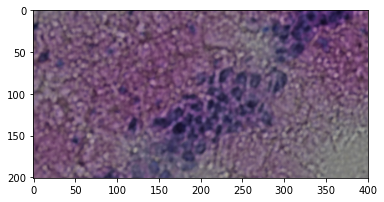

In [8]:
display(crop)
plt.imshow(crop['image'])

Both cropping functions allow you to mask the crop with a circle (`mask_circle`) and scale the crop (`scale`). This is useful for feature extraction from the images to make sure that features are only calculated on the tissue which was under the visium spot.

In [9]:
# scale crop
crop_scaled = img.crop_center(3000,4000, xr=200, yr=100, scale=0.5)
display(crop_scaled)

ImageContainer object with 2 layers
    image: y (100), x (200), channels (3)
    mask: y (100), x (200), segmentation (1)

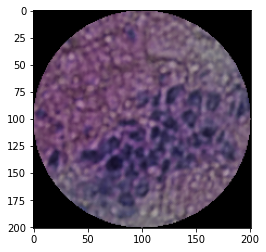

In [10]:
# mask crop (only for square images)
crop_masked = img.crop_center(3000,4000, xr=100, yr=100, mask_circle=True)
plt.imshow(crop_masked['image'])

crops that cross the border of the original image are padded with `cval`

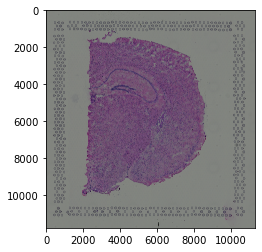

In [11]:
plt.imshow(img['image'])

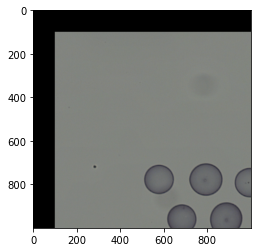

In [12]:
crop_padded = img.crop_corner(-100,-100, xs=1000, ys=1000, cval=0)
plt.imshow(crop_padded['image'])

## Extract crops using crop_spot_generator
We can crop a series of images using the `crop_spot_generator`. This generates crops that are centered on the visium spots defined in `adata`. For each spot it returns `(crop, obs_id)`.
Per default, the crop has the size of the spot diameter. From these crops, we can calculate features. See REF TO FEATURE EXTRACTION TUTORIAL

In [13]:
adata, img = sq.read_visium_data(dataset_folder)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
crop_iter = img.generate_spot_crops(adata)
crop, obs_id = next(crop_iter)
print(obs_id, crop.shape)

AAACAAGTATCTCCCA-1 (89, 89)


In [15]:
crop1, _ = next(crop_iter)

In [16]:
crop1.data.image

<xarray.DataArray 'image' (y: 89, x: 89, channels: 3)>
array([[[140,  81, 132],
        [147,  84, 140],
        [137,  76, 129],
        ...,
        [153, 107, 146],
        [167, 126, 160],
        [161, 115, 154]],

       [[151,  90, 143],
        [152,  89, 147],
        [147,  85, 140],
        ...,
        [151, 104, 146],
        [157, 111, 150],
        [166, 119, 160]],

       [[138,  78, 132],
        [138,  77, 135],
        [138,  74, 134],
        ...,
...
        ...,
        [107,  66,  99],
        [123,  82, 113],
        [133,  90, 123]],

       [[128,  94, 120],
        [120,  85, 113],
        [100,  66,  95],
        ...,
        [104,  62,  98],
        [112,  70, 106],
        [117,  73, 110]],

       [[135, 100, 127],
        [135, 100, 126],
        [117,  80, 110],
        ...,
        [108,  64, 103],
        [108,  64, 107],
        [107,  63, 108]]], dtype=uint8)
Coordinates:
  * channels  (channels) int64 1 2 3
Dimensions without coordinates: y, x
Attributes:
    transform:               (1.0, 0.0, 0.0, 0.0, 1.0, 0.0)
    res:                     (1.0, -1.0)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    TIFFTAG_MAXSAMPLEVALUE:  255

In [17]:
crop.data.image



<xarray.DataArray 'image' (y: 89, x: 89, channels: 3)>
array([[[102,  71, 111],
        [108,  77, 123],
        [125,  94, 144],
        ...,
        [110,  88, 106],
        [ 95,  72,  87],
        [ 78,  51,  66]],

       [[ 88,  58,  99],
        [102,  71, 117],
        [114,  83, 133],
        ...,
        [116,  94, 109],
        [130, 105, 118],
        [117,  90, 106]],

       [[ 97,  66, 111],
        [100,  69, 117],
        [105,  73, 125],
        ...,
...
        ...,
        [110,  72, 111],
        [119,  78, 117],
        [122,  81, 118]],

       [[118,  99, 121],
        [113,  95, 117],
        [123, 105, 128],
        ...,
        [122,  85, 123],
        [121,  81, 116],
        [117,  79, 109]],

       [[110,  92, 106],
        [133, 113, 130],
        [155, 136, 152],
        ...,
        [136,  96, 136],
        [130,  91, 124],
        [118,  82, 109]]], dtype=uint8)
Coordinates:
  * channels  (channels) int64 1 2 3
Dimensions without coordinates: y, x
Attributes:
    transform:               (1.0, 0.0, 0.0, 0.0, 1.0, 0.0)
    res:                     (1.0, -1.0)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0)
    TIFFTAG_MAXSAMPLEVALUE:  255

Lets plot the location of the obs that we have just cropped

8230 7237


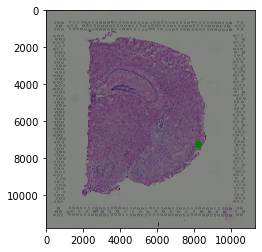

In [18]:
x , y = adata[obs_id].obsm['spatial'][0]
print(x, y)
plt.scatter(x, y, c='green')
plt.imshow(img.data['image'].transpose('y', 'x', ...).data)

### Extract crops with more context
Use the `size` argument to extract crops with a larger neighbourhood.
Note that the function will add `cval` (0 by default) when the range is outside the image.

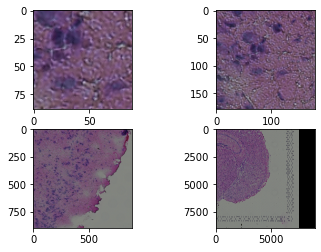

In [19]:
fig, axes = plt.subplots(2,2)
for ax, size in zip(axes.flat, [1,2,10,100]):
    crop, obs_id = next(img.generate_spot_crops(adata, size=size, cval=0))
    ax.imshow(crop['image'])

## Extract crops using generate_equal_crops
Besides iterating for all spots, we can also separate the image in equally sized crops. These can then be used to apply processing functions to the image, even if the image is too large to be processed at once. See REF TO PROCESSING TUTORIAL for more information.

AAACAAGTATCTCCCA-1 (1000, 1000)


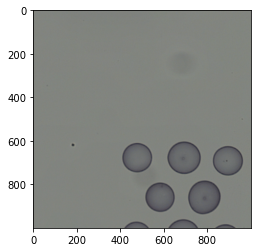

In [20]:
crop_iter = img.generate_equal_crops(1000,1000)
crop, x, y = next(crop_iter)
print(obs_id, crop.shape)
plt.imshow(crop['image'])

After cropping the image and processing it, we can assemble the crops in one image object again using `uncrop_img`. This is used in the `process` function (REF TO PROCESSING TUTORIAL).

Note that a few pixels at the border of the image are lost when the size of the image is not divisible by the size of the crops.

In [21]:
# create all crops
crop_iter = img.generate_equal_crops(1000, 2000)
xcoords = []
ycoords = []
crops = []
for crop, x, y in crop_iter:
    crops.append(crop)
    xcoords.append(x)
    ycoords.append(y)

In [22]:
# recreate image
uncropped_img = sq.im.ImageContainer.uncrop_img(crops, xcoords, ycoords, shape=img.shape)

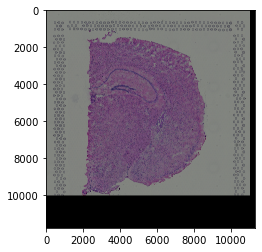

In [23]:
plt.imshow(uncropped_img['image'])

# Extract crops using a fluorescence dataset

In [24]:
# set path to dataset
BASE_PATH = "../../data"
dataset_folder = os.path.join(BASE_PATH, "2020_10XFluoVisium_MouseBrain2_giovanni.palla")
adata, img = sq.read_visium_data(dataset_folder)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Multi-page tiff images with 1 channel (like this fluorescence tiff) are automatically merged in one data array. Cropping will return each fluoresecent image as a channel

In [25]:
img

ImageContainer object with 1 layers
    image: y (24240), x (24240), channels (3)

When cropping, we need to manually set the dtype to be uint8 to allow plotting with matplotlib

(179, 179) uint8


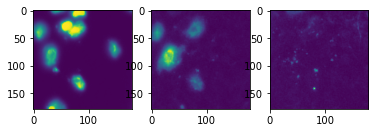

In [26]:
crop, obs_id = next(img.generate_spot_crops(adata, dtype='uint8'))
print(crop.shape, crop['image'].dtype)
fig, axes = plt.subplots(1,3)
for i, ax in enumerate(axes.flat):
    ax.imshow(crop['image'][:,:,i])

In [27]:
import xarray as xr

In [28]:
xr.Dataset()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*